The Client has thousands of events produced by his monitoring system every day. In
our case, events are parsed and represented as strings.

    ● The Client wants to have a daily report with events summary. Tickets data for 1 day is
    provided in the form of a csv file (tickets.csv) in the test task archive. There is 1
    column: “ticket”, without an index.
    Task description:
    Candidate should deliver Jupyter Notebook with the following functionality:
    ● Basic data analysis, visualisation.
    ● Clustering. Results evaluation and analysis.
    ● Summary of tickets in compact form (say, you need to include it in the report).

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
import re
from nltk.stem import PorterStemmer
from sklearn.cluster import MiniBatchKMeans
import sys
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from sklearn.cluster import DBSCAN
import seaborn as sns

In [2]:
df = pd.read_csv(r'd:\tickets.csv')
df.head()

,ticket
0,eit-prismadm01.tgna.tegna.com: System or agent...
1,ATL-NELLC-N9K-2: Interface state changed to op...
2,vaqupdtoms01: Device Failed Availability Check...
3,test-vm-01: VMware: VM CPU Usage Has Exceeded ...
4,NTNX-local-ds-19SM6J290326-B: Device Failed Av...


we can assume that the structure of the ticket is as follows

    [login]:[message]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5446 entries, 0 to 5445
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ticket  5446 non-null   object
dtypes: object(1)
memory usage: 42.7+ KB


In [4]:
%%time

# lowercase translation
df['ticket'] = df['ticket'].apply(lambda x: x.lower())

def get_login(x):
    try:
        return  re.search(r'.+?:', x).group(0)[:-1].replace(' ','')
    except:
        return '###ERROR'  
    
def get_text(x):
    try:
        text =  re.search(r':.+', x).group(0)[1:]
    except:
        text = x 
    return " ".join(re.sub(r'[^a-z]', ' ', text).split())
    
    
df['login'] =  df.apply(lambda x:  get_login(x['ticket']), axis =1 )
df['text'] =  df.apply(lambda x:  get_text(x['ticket']), axis =1 )
df['text'] = df['text'].apply(nltk.word_tokenize)
# lemmatization
sys.setrecursionlimit(10000)
stemmer = PorterStemmer() 
df['text'] = df['text'].apply(lambda x: [stemmer.stem(y) for y in x])
df['text'] = df['text'].apply(lambda x: ' '.join(x))


Wall time: 1.8 s


In [5]:
df[df['login'] == '###ERROR']

,ticket,login,text
2169,bgp tunnels down,###ERROR,bgp tunnel down
2517,bgp is down.,###ERROR,bgp is down
3867,vivo & sao paulo brazil bgp neighbors not form...,###ERROR,vivo sao paulo brazil bgp neighbor not form ne...
3886,bgp tunnel down - tmdata,###ERROR,bgp tunnel down tmdata
3927,critical - bgp tunnels for various carriers down,###ERROR,critic bgp tunnel for variou carrier down
4017,ashburn bgp tunnel down (cotas,###ERROR,ashburn bgp tunnel down cota
4666,"need confirmation on ""down"" bgp tunnels in ash...",###ERROR,need confirm on down bgp tunnel in ashburn dat...


A total of 7 entries do not match the general ticket syntax. It's good.

In [6]:
%%time
# create td-idf matrix
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 
tf_idf = count_tf_idf.fit_transform(df['text'])

Wall time: 757 ms


[nltk_data] Downloading package stopwords to C:\Users\Кулаков
[nltk_data]     Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


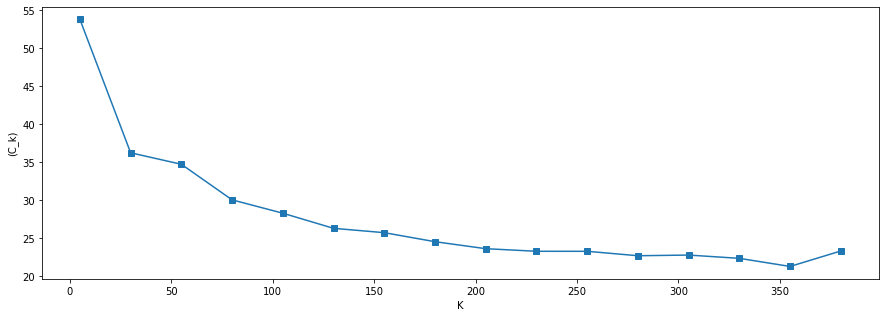

In [7]:
# get the optimal number of clusters
inertia = []
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
for k in range(5,400,25):
    mbk  = MiniBatchKMeans(n_clusters=k,init='random', random_state=1).fit(tf_idf)
    inertia.append(np.sqrt(mbk.inertia_))
plt.plot(range(5,400,25),inertia,marker='s')
plt.xlabel('K')
plt.ylabel('(C_k)')
plt.show()

using the elbow method, we get the optimal number of clusters 70-80

In [8]:
# create clusters by DBSCAN
db = DBSCAN(eps=1, min_samples=1).fit(tf_idf)
Num = db.labels_

df2 = {"num_cluster": Num}
dfMBK = pd.DataFrame(df2)
df = pd.concat([df,dfMBK], axis=1)
df['text'] = df['text'] + ' '
df['num_words'] = df.apply(lambda x: len(word_tokenize(x.text)), axis = 1)

# group data by claster
group = df.groupby(by = 'num_cluster').agg({'text':'sum', 'ticket':'count','login':'nunique', 'num_words':'median'})

# get the most frequent words in cluster
group['text_mas'] = group['text'].apply(lambda x:  FreqDist(word_tokenize(x)))
group['text_mas'] = group.apply(lambda x:  x.text_mas.most_common(max(5, int(x.num_words/2))), axis = 1)

# get a ticket view based on the most frequent words
df = df.merge(group['text_mas'], left_on  = 'num_cluster', how = 'left' , right_index = True )

def represent(text_mas, most_f):
    word_list = []
    for i in text_mas:
        word_list.append(i[0])
    return ' '.join([x for x in most_f.split() if x in word_list])

df['represent'] = df.apply(lambda x: represent(x['text_mas'], x['text']), axis = 1)

# get the most frequent ticket view in the cluster
func = lambda s: s.value_counts().idxmax() 
group = group.merge(df.groupby(by = 'num_cluster').agg({'represent':func }) , how = 'left',  right_index = True,  left_index = True)
display(group.head())
print()
print('number of clusters ' +str(group.shape[0]))

,text,ticket,login,num_words,text_mas,represent
num_cluster,,,,,,
0,system or agent ha recent restart system or ag...,860,363,6.0,"[(system, 860), (or, 860), (agent, 860), (ha, ...",system or agent ha recent
1,interfac state chang to oper down name etherne...,300,169,14.0,"[(state, 532), (interfac, 334), (previou, 297)...",interfac state chang to oper down previou state
2,devic fail avail check udp snmp devic fail ava...,1454,1013,16.5,"[(avail, 2770), (devic, 2476), (fail, 1454), (...",devic fail avail check compon devic is not ava...
3,vmware vm cpu usag ha exceed threshold current...,1101,572,9.0,"[(exceed, 864), (threshold, 864), (ha, 660), (...",host ha exceed threshold current
4,requir servic not run tomcat requir servic not...,730,256,5.0,"[(servic, 625), (not, 624), (run, 624), (requi...",requir servic not run tomcat



number of clusters 71


using DBSCAN we also get the optimal number of clusters.

In [9]:
group['num_words'].describe()

count    71.000000
mean     11.359155
std       4.669187
min       4.000000
25%       8.000000
50%      10.000000
75%      15.000000
max      22.000000
Name: num_words, dtype: float64

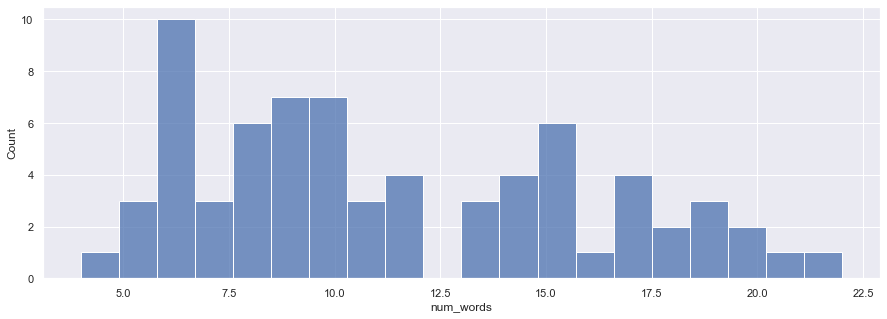

In [10]:
sns.set(rc={'figure.figsize':(15,5)})
sns.histplot(data=group, x="num_words", bins = 20)
plt.show()

In a ticket, an average of 11 words, the most frequent - 6 words

In [11]:
group['login'].describe()

count      71.000000
mean       41.380282
std       145.375805
min         1.000000
25%         1.000000
50%         3.000000
75%        11.000000
max      1013.000000
Name: login, dtype: float64

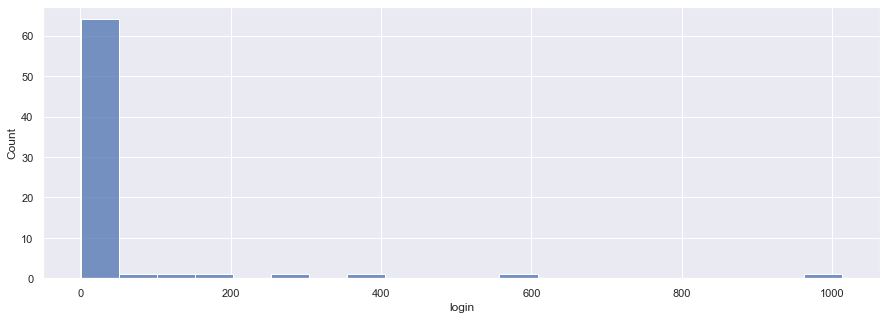

In [12]:
sns.set(rc={'figure.figsize':(15,5)})
sns.histplot(data=group, x="login", bins = 20)
plt.show()

a ticket from a cluster, on average, comes with 3 logins, but there are those that come from a huge number. Most likely, this is some kind of automated message.

In [13]:
group['ticket'].describe()

count      71.000000
mean       76.704225
std       248.878823
min         1.000000
25%         1.000000
50%         4.000000
75%        25.500000
max      1454.000000
Name: ticket, dtype: float64

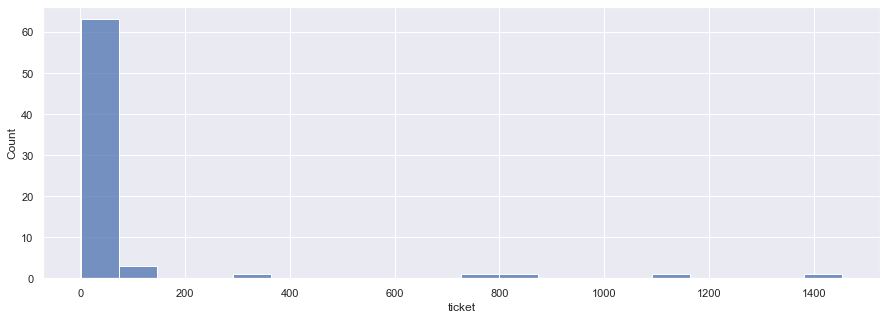

In [14]:
sns.set(rc={'figure.figsize':(15,5)})
sns.histplot(data = group, x="ticket",  bins = 20)
plt.show()

on average, there are 4 tickets in a cluster, but there are a lot of duplicate messages.

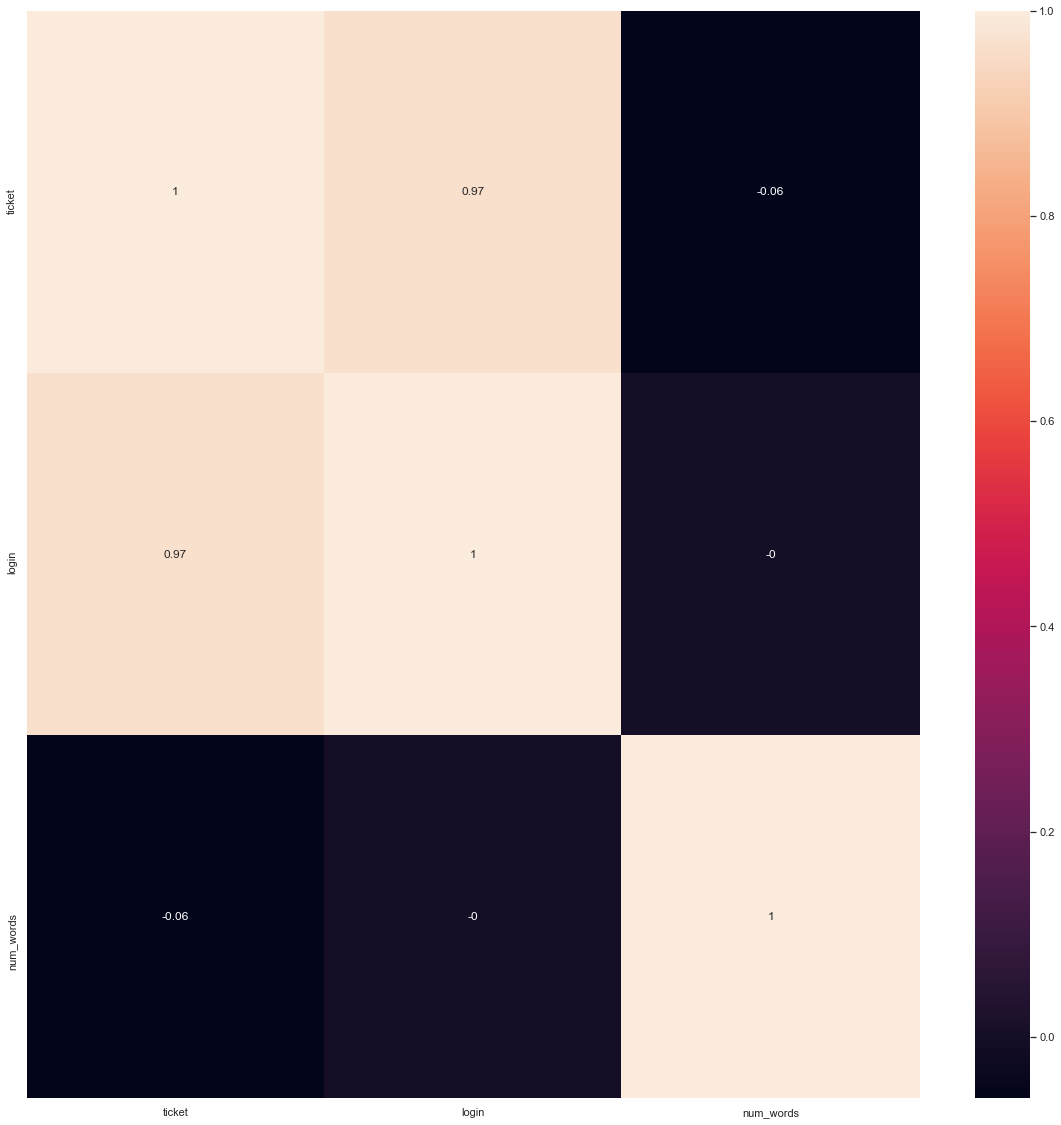

In [15]:
fig, ax = plt.subplots(figsize=(20,20))
corr = round(group[['ticket','login','num_words']].corr(), 2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot = True, ax = ax)
plt.show()

obvious connection. The more logins, the more tickets.

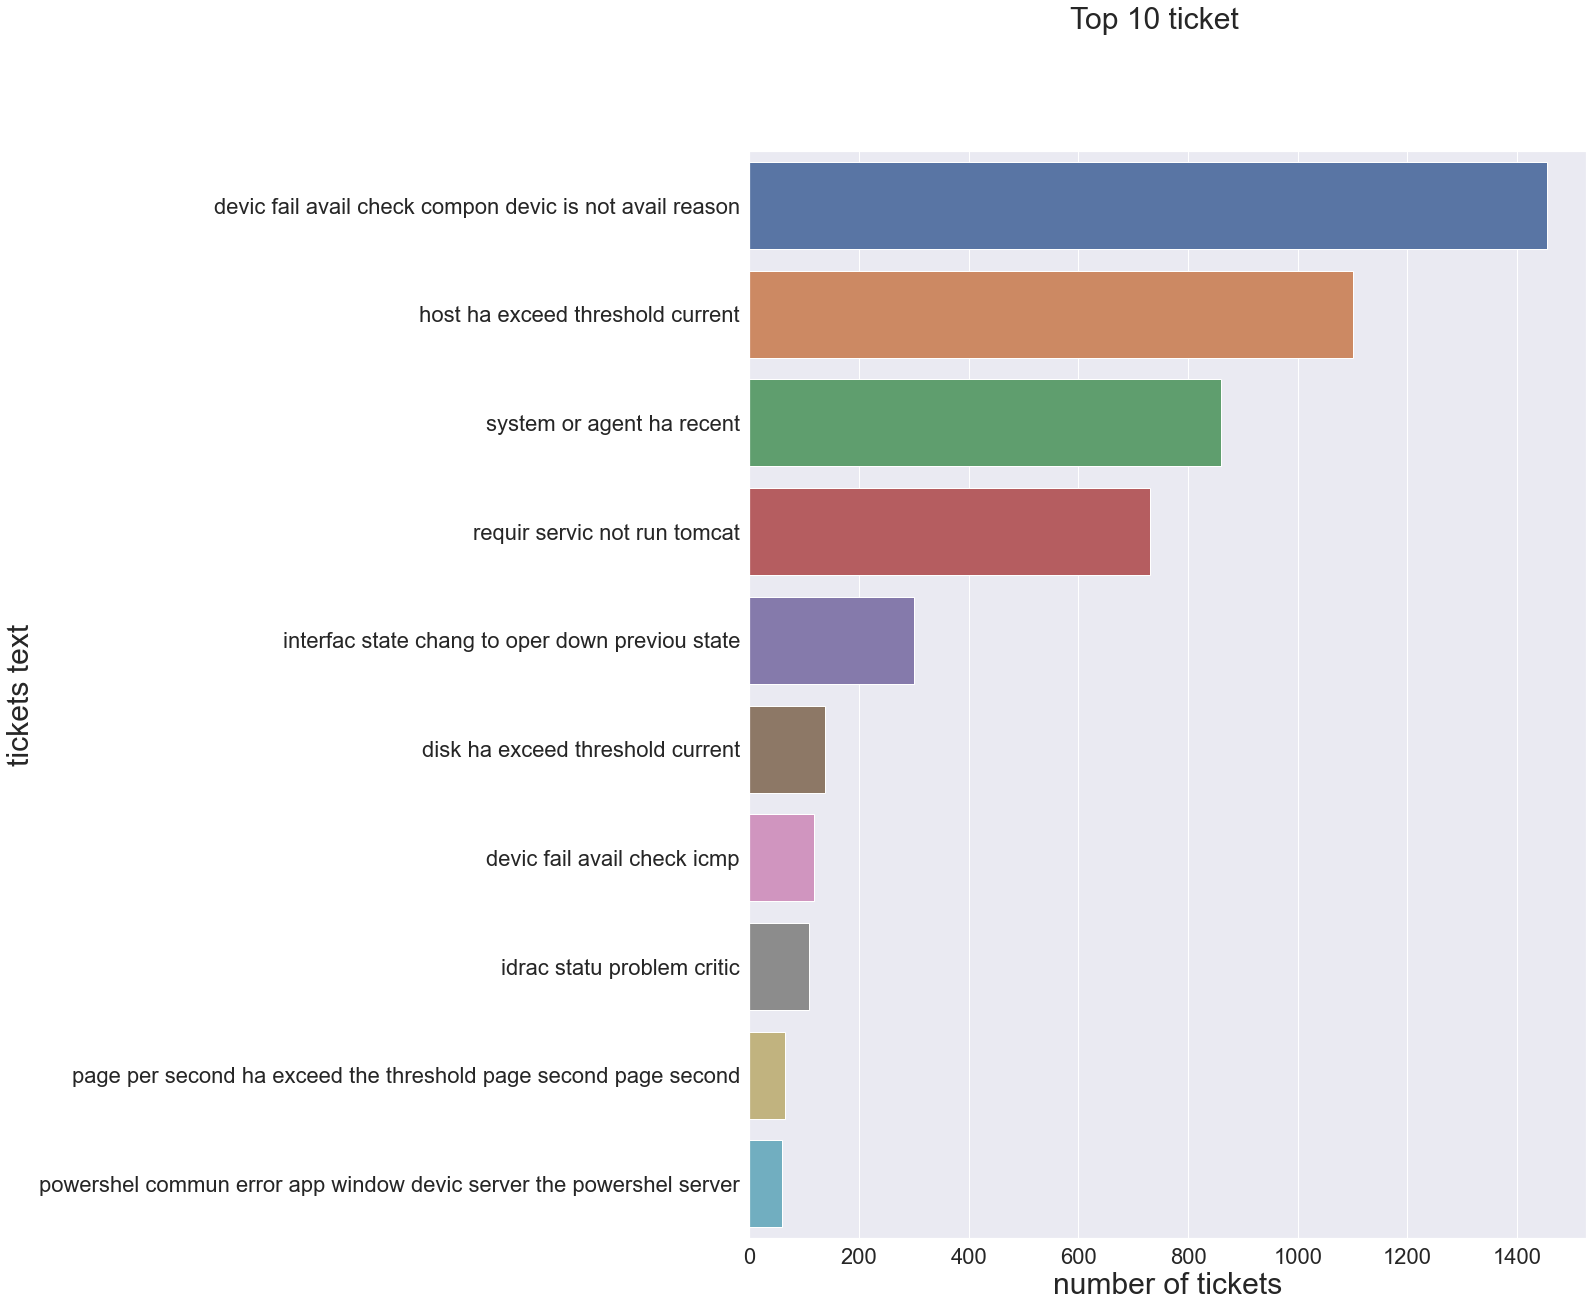

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(15, 20))
sns.barplot(data = group.sort_values('ticket', ascending = False)[:10], y="represent", x="ticket",  ax = axes)
sns.set(font_scale = 2)
axes.set_ylabel('tickets text', fontsize = 30)
axes.set_xlabel('number of tickets', fontsize = 30)
fig.suptitle('Top 10 ticket', fontsize = 30)

plt.show()